In [3]:
# Load dependencies
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
from cosmos_helper_funcs import *
from defect_pixel_funcs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Load dark current data
dark_current_folder_CMS = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Dark Current/CMS'
dark_current_folder_HSHGRS = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Dark Current/HS_HG_RS'
# Each element of stacks is a dictionary containing header information and the image data.
# The image data is an NxMxL array, where N is the number of frames, M is the number of rows,
# and L is the number of columns.
stacks_CMS = get_stacks(dark_current_folder_CMS, get_mean_img=True, get_median_img=True, num_imgs=0)
stacks_HSHGRS = get_stacks(dark_current_folder_HSHGRS, get_mean_img=True, get_median_img=True, num_imgs=0)


In [47]:
gain_CMS = 4.0
gain_HSHGRS = 1 / 1.024
# Sort stacks by exposure time to get bias frame
stacks_CMS = sorted(stacks_CMS, key=lambda x: x['exposure_ms'])
stacks_HSHGRS = sorted(stacks_HSHGRS, key=lambda x: x['exposure_ms'])
bias_frame_CMS = stacks_CMS[0]['mean_img']
bias_frame_HSHGRS = stacks_HSHGRS[0]['mean_img']
long_exposure_stacks_CMS = stacks_CMS[1:]
long_exposure_stacks_HSHGRS = stacks_HSHGRS[1:]
# Sort long exposure stacks by temperature
long_exposure_stacks_CMS = sorted(long_exposure_stacks_CMS, key=lambda x: int(x['cam_temp_Cel']))
long_exposure_stacks_HSHGRS = sorted(long_exposure_stacks_HSHGRS, key=lambda x: int(x['cam_temp_Cel']))
temps_CMS = np.zeros(len(stacks_CMS) - 1)
dc_rate_frames = np.zeros((len(stacks_CMS) - 1, 8120, 8120))
for i, stack in enumerate(long_exposure_stacks_CMS):
    temps_CMS[i] = stack['cam_temp_Cel']
    clean_frame = stack['mean_img'] - bias_frame_CMS
    dc_rate_frame = clean_frame / (int(stack['exposure_ms']) / 1000) / gain_CMS
    dc_rate_frames[i] = dc_rate_frame
    mean_val = np.mean(dc_rate_frame)
    median_val = np.median(dc_rate_frame)
    percentile_1 = np.percentile(dc_rate_frame, 1)
    percentile_95 = np.percentile(dc_rate_frame, 95)
    # plt.hist(dc_rate_frame.flatten(), bins=100, range=(min([0,percentile_1]), percentile_95))
    # # Put vertical lines labeling the mean, median, and rms values
    # plt.axvline(mean_val, color='r', linestyle='dashed', linewidth=1)
    # plt.axvline(median_val, color='g', linestyle='dashed', linewidth=1)
    # # Write the temperature, mean value, median value, and rms value on the plot. Color the text
    # # to match the lines
    # plt.text(0.95, 0.95, f'Temperature: {stack["cam_temp_Cel"]} C', ha='right', va='top', transform=plt.gca().transAxes)
    # plt.text(0.95, 0.9, f'Mean: {mean_val:.3f} e-/pix/s', ha='right', va='top', color='r', transform=plt.gca().transAxes)
    # plt.text(0.95, 0.85, f'Median: {median_val:.3f} e-/pix/s', ha='right', va='top', color='g', transform=plt.gca().transAxes)
    # plt.xlabel('Dark Current Rate (e-/pix/s)')
    # plt.ylabel('Number of Pixels')
    # plt.show()
# dc_vals_CMS = np.zeros(len(stacks_CMS) - 1)
# mean_vals_CMS = np.zeros(len(stacks_CMS) - 1)
# rms_vals_CMS = np.zeros(len(stacks_CMS) - 1)
# bias_val_CMS = 0
# temps_HSHGRS = np.zeros(len(stacks_HSHGRS) - 1)
# dc_vals_HSHGRS = np.zeros(len(stacks_HSHGRS) - 1)
# bias_val_HSHGRS = 0
# i = 0
# j = 0
# for stack in stacks_CMS:
#     mean_val = np.mean(stack['mean_img'])
#     rms_val = np.sqrt(np.mean(stack['mean_img'] ** 2))
#     if stack['exposure_ms'] == '600000':
#         temps_CMS[i] = stack['cam_temp_Cel']
#         dc_vals_CMS[i] = mean_val
#         i += 1
#     else:
#         bias_val_CMS = mean_val
# for stack in stacks_HSHGRS:
#     mean_val = np.mean(stack['mean_img'])
#     if stack['exposure_ms'] == '600000':
#         temps_HSHGRS[j] = stack['cam_temp_Cel']
#         dc_vals_HSHGRS[j] = mean_val
#         j += 1
#     else:
#         bias_val_HSHGRS = mean_val
# # Sort by temperature
# sort_indices_CMS = np.argsort(temps_CMS)
# temps_CMS = temps_CMS[sort_indices_CMS]
# dc_vals_CMS = dc_vals_CMS[sort_indices_CMS]
# sort_indices_HSHGRS = np.argsort(temps_HSHGRS)
# temps_HSHGRS = temps_HSHGRS[sort_indices_HSHGRS]
# dc_vals_HSHGRS = dc_vals_HSHGRS[sort_indices_HSHGRS]
# print(dc_vals_CMS)

In [ ]:
%matplotlib inline
neg_25_frame = dc_rate_frames[2]
defectMap = plot_defect_hist(neg_25_frame, show_gaussian=False, clip_type='absolute', cutoff_level=1.0, cut_low=False)[0]

In [ ]:
# Figure out the number of defect pixels in the bottom 100 rows
num_defect_pixels = np.sum(defectMap[-100:])
print(num_defect_pixels)

In [ ]:
# Fit function to dark current vs. temperature to find doubling temperature
def func(x, a, b):
    return a * np.exp(b * x)

from scipy.optimize import curve_fit
popt_CMS, pcov_CMS = curve_fit(func, temps_CMS, dc_vals_CMS)
popt_HSHGRS, pcov_HSHGRS = curve_fit(func, temps_HSHGRS, dc_vals_HSHGRS)
print('Doubling temperature for CMS mode: ', np.log(2) / popt_CMS[1])
print('Doubling temperature for 14b High Speed Rolling Shutter mode: ', np.log(2) / popt_HSHGRS[1])


In [ ]:
%matplotlib inline
# Load spot data
filename = '/Users/layden/Downloads/spot_data.csv'
spot_data = np.genfromtxt(filename, delimiter=',', skip_header=1)
spot_data[:, 1] -= 14
spot_data[:, 1] = spot_data[:, 1] / np.max(spot_data[:, 1])
spot_data[:,0] = spot_data[:,0] * 0.2 - 7.88
plt.plot(spot_data[:,0], spot_data[:,1])
# Make axis titles larger
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Position (um)', fontsize=16)
plt.ylabel('Relative Intensity', fontsize=16)
# Write the FWHM value (1.2)
plt.text(-7.5, 0.4, 'FWHM: 1.2 um', fontsize=14)
plt.text(-7.5, 0.1, 'Diffraction Limit\n FWHM: 1.1 um', fontsize=14)
plt.show()

Try to extract the read noise using dark current data

In [4]:
data_folder = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Read Noise/Dark Images'
stacks = get_stacks(data_folder, get_mean_img=True, get_var_img=False)

Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Read Noise/Dark Images/HSHG_RS_dark_30000ms_15C 2024-09-28 06_41_17.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Read Noise/Dark Images/HSHG_RS_dark_60000ms_15C 2024-09-28 06_51_54.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Read Noise/Dark Images/HSHG_RS_dark_1us_-25C 2024-09-28 22_03_08.fits
Now reading /Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/Analysis Images/Read Noise/Dark Images/HSHG_RS_dark_30000ms_10C 2024-09-28 09_44_26.fits


In [6]:
poly_coefficients = np.array([-1.11332005e-31, 9.83489385e-28, -3.83481258e-24,  8.69244319e-21,
                              -1.26915294e-17, 1.24869164e-14, -8.40577356e-12,  3.84719377e-09,
                              -1.16671178e-06, 2.24630045e-04, -2.65071660e-02,  3.25187633e+00])


In [7]:
subtracted_30s_frames = np.array([img - stacks[2]['mean_img'] for img in stacks[0]['imagestack']])
# Set values that are greater than 1600 to np.NaN
subtracted_30s_frames[subtracted_30s_frames > 1450] = np.NaN
corrected_30s_frames = np.polyval(poly_coefficients, subtracted_30s_frames) * subtracted_30s_frames

In [16]:
subtracted_60s_frames = np.array([img - stacks[2]['mean_img'] for img in stacks[3]['imagestack']])
# Set values that are greater than 1600 to np.NaN
subtracted_60s_frames[subtracted_60s_frames > 1450] = np.NaN
corrected_60s_frames = np.polyval(poly_coefficients, subtracted_60s_frames) * subtracted_60s_frames

In [17]:
avg_frame_30s = np.mean(corrected_30s_frames, axis=0)
var_frame_30s = np.var(corrected_30s_frames, axis=0, ddof=1)
avg_frame_60s = np.mean(corrected_60s_frames, axis=0)
var_frame_60s = np.var(corrected_60s_frames, axis=0, ddof=1)

In [18]:
print(np.nanmedian(avg_frame_60s))

205.77015429013227


In [25]:
from scipy.optimize import curve_fit
def gaussian(x, A, mu, sigma, C):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2)) + C

49.70643697853737 57.16115214354052
[1.00021028e+07 4.52685529e+01 1.50393398e+02 2.25803273e+04] [1.75545736e+07 5.23926226e+01 8.47035672e+01 3.54428702e+04]


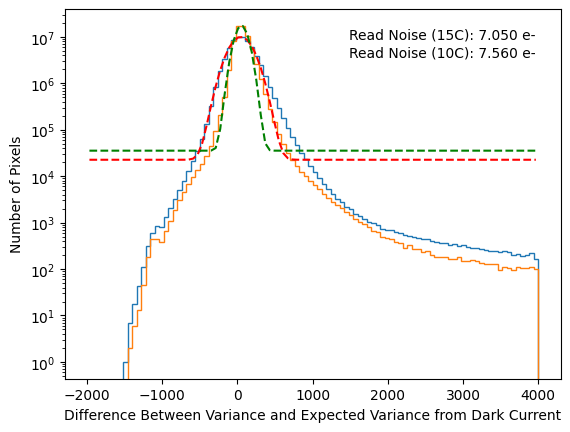

In [28]:
%matplotlib inline
gain = 1 / 1.021 # ADU/e-
read_variance_array_30s = var_frame_30s / gain - avg_frame_30s
read_variance_array_60s = var_frame_60s / gain - avg_frame_60s
print(np.nanmedian(read_variance_array_30s), np.nanmedian(read_variance_array_60s))
read_noise_30s = np.sqrt(np.nanmedian(read_variance_array_30s))
read_noise_60s = np.sqrt(np.nanmedian(read_variance_array_60s))
# Make histograms just lines, not filled bars
hist1, bin_edges1, patches1  = plt.hist(read_variance_array_30s.flatten(), bins=100, range=(-2000, 4000), histtype='step', label='30s Dark Frame')
hist2, bin_edges2, patches2 = plt.hist(read_variance_array_60s.flatten(), bins=100, range=(-2000, 4000), histtype='step', label='60s Dark Frame')
# Fit Gaussians to histograms
bin_centers1 = (bin_edges1[:-1] + bin_edges1[1:]) / 2
bin_centers2 = (bin_edges2[:-1] + bin_edges2[1:]) / 2
popt1, pcov1 = curve_fit(gaussian, bin_centers1, hist1, p0=[1E7, 0, 500, 1000])
popt2, pcov2 = curve_fit(gaussian, bin_centers2, hist2, p0=[1E7, 0, 500, 1000])
print(popt1, popt2)
# Plot the fitted Gaussians
plt.plot(bin_centers1, gaussian(bin_centers1, *popt1), 'r--', label='Fit to 15C Dark Frame')
plt.plot(bin_centers2, gaussian(bin_centers2, *popt2), 'g--', label='Fit to 10C Dark Frame')
# Print medians
plt.text(0.95, 0.95, f'Read Noise (15C): {np.sqrt(np.nanmedian(read_variance_array_30s)):.3f} e-', ha='right', va='top', transform=plt.gca().transAxes)
plt.text(0.95, 0.9, f'Read Noise (10C): {np.sqrt(np.nanmedian(read_variance_array_60s)):.3f} e-', ha='right', va='top', transform=plt.gca().transAxes)
plt.xlabel('Difference Between Variance and Expected Variance from Dark Current')
plt.ylabel('Number of Pixels')
plt.yscale('log')
plt.show()

In [28]:
%matplotlib qt
plt.imshow(read_noise_array_60s, vmin=0, vmax=20)
plt.colorbar()
plt.show()